<a href="https://colab.research.google.com/github/yang-su2000/Authorship-Identification-with-NLP/blob/main/AML_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 100

import torch
from torch import Tensor
print(torch.__version__)
from sklearn import preprocessing
from transformers import DistilBertTokenizer, BertTokenizer

from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

random_seed = 42
np.random.seed = 42
torch.random.seed = 42

1.13.0+cu117


# Preprocess (skip)

### Prepare Paper Node

In [ ]:
df = pd.read_csv('Citation Network/CN1_affiliated_labeled_90k.csv', 
                 dtype={'ref': str, 'title': str, 'authors': str, 'year': int, 'pub': str, 
                        'index': int, 'abstract': str, 'affiliation': str, 'label': int})
df.rename(columns={'index':'original_index','refs':'original_refs'}, inplace=True)
df.head()

In [ ]:
index_map = {}
for i, idx in enumerate(df['original_index'].values):
    index_map[idx] = i
print(len(index_map))
ref_values = []
for ls in df['original_refs'].values:
    original_refs = ls[1:-1].split(', ')
    refs = []
    for ref in original_refs:
        ref = ref[1:-1]
        if ref == '' or int(ref) not in index_map:
            continue
        refs.append(str(index_map[int(ref)]))
    ref_values.append('[' + ', '.join(refs) + ']')
df['index'] = df.index
df['refs'] = ref_values
df.head()

In [ ]:
paper_df = df[['index', 'refs', 'title']].rename(columns={'index':'paper_id', 'refs': 'paper_refs', 'title': 'paper_title'})
paper_df.head()

In [ ]:
paper_df.to_csv('Citation Network/paper_df.csv', index=False)

### Prepare Author Node

In [ ]:
author_set = set()
for ls in df['authors'].values:
    authors = ls[1:-1].split(', ')
    for author in authors:
        author_set.add(author[1:-1])
print(len(author_set))

In [ ]:
author_feats = pd.read_csv('Citation Network/author_and_features (1).csv').drop(columns=['Unnamed: 0'])
author_feats.head()

In [ ]:
affiliation_map = {}
for row in author_feats.values:
    author, affiliation = row[0], row[1]
    if author in author_set:
        affiliation_map[author[:-1]] = affiliation[:-1]
for author in author_set:
    if author not in affiliation_map:
        affiliation_map[author] = 'No record; '
print(len(affiliation_map))
author_df = pd.DataFrame({'author_name': affiliation_map.keys(), 'author_info': affiliation_map.values()})
author_df.insert(0, 'author_id', np.arange(len(affiliation_map)))
author_df.head()

In [ ]:
author_df.to_csv('Citation Network/author_df.csv', index=False)

In [ ]:
author_map = {}
for author_id, author_name in zip(author_df['author_id'], author_df['author_name']):
    author_map[author_name] = author_id
len(author_map)

### Prepare Author-Paper Edge

In [ ]:
edge_df = pd.DataFrame()
paper_ids = []
author_ids = []
for index, authors, label in zip(df['index'], df['authors'], df['label']):
    if label == 0:
        continue
    for author in authors[1:-1].split(', '):
        author = author[1:-1]
        if author in author_map:
            paper_ids.append(index)
            author_ids.append(author_map[author])
edge_df['author_id'] = author_ids
edge_df['paper_id'] = paper_ids
print(len(edge_df))
edge_df.head()

In [ ]:
edge_df.to_csv('Citation Network/edge_df.csv', index=False)

# Main

### Build Graph

In [ ]:
author_df = pd.read_csv('Citation Network/author_df.csv')
print(len(author_df))
author_df.head()

46483


,author_id,author_name,author_info
0,0,Richard Albert Uhlig,No record;
1,1,Holly C. Beale,No record;
2,2,Lars-Erik Jendrossek,No record;
3,3,Stephen Lau,No record;
4,4,Steffen Abraham,No record;


In [ ]:
paper_df = pd.read_csv('Citation Network/paper_df.csv')
print(len(paper_df))
paper_df.head()

89128


,paper_id,paper_refs,paper_title
0,0,[],"Embedded Software and Systems: Second International Conference, ICESS 2005, Xi'an, China, Decemb..."
1,1,[],C++ Cookbook (Cookbooks (O'Reilly))
2,2,[],Special Edition Using Microsoft Office Word 2003
3,3,"[78486, 83024, 83497]",ALP: Efficient support for all levels of parallelism for complex media applications
4,4,[],ActionScript 2.0 Language Reference for Macromedia Flash 8


In [ ]:
edge_df = pd.read_csv('Citation Network/edge_df.csv', dtype=int)
print(len(edge_df))
edge_df.head()

68944


,author_id,paper_id
0,17976,0
1,5533,0
2,25,0
3,16199,0
4,43847,0


In [ ]:
author_max_length = 32
title_max_length = 32
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
author_info = [tokenizer(text, padding='max_length', max_length = author_max_length, truncation=True, return_tensors="pt")
               for text in author_df['author_info'] + 'My name is ' + author_df['author_name']]
paper_title = [tokenizer(text, padding='max_length', max_length = title_max_length, truncation=True, return_tensors="pt") 
               for text in paper_df['paper_title']]

In [ ]:
author_feat = torch.cat([text['input_ids'] for text in author_info])
paper_feat = torch.cat([text['input_ids'] for text in paper_title])
print(author_feat.shape, paper_feat.shape)

torch.Size([46483, 32]) torch.Size([89128, 32])


In [ ]:
data = HeteroData()

# Save node indices:
data["author"].node_id = torch.arange(len(author_df))
data["paper"].node_id = torch.arange(len(paper_df))

# Add the node features and edge indices:
data["author"].author_info = author_feat
data["paper"].paper_title = paper_feat
data["author", "writes", "paper"].edge_index = torch.from_numpy(edge_df.values.T)

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:

print(data)
transform = T.Compose([T.ToUndirected(), T.AddSelfLoops()])
data = transform(data)
print(data)

assert data.node_types == ["author", "paper"]
assert data.edge_types == [("author", "writes", "paper"),
                           ("paper", "rev_writes", "author")]
assert data["author"].num_nodes == 46483
assert data["author"].num_features == 0
assert data["paper"].num_nodes == 89128
assert data["paper"].num_features == 0
assert data["author", "writes", "paper"].num_edges == 68944
assert data["paper", "rev_writes", "author"].num_edges == 68944

HeteroData(
  author={
    node_id=[46483],
    author_info=[46483, 32]
  },
  paper={
    node_id=[89128],
    paper_title=[89128, 32]
  },
  (author, writes, paper)={ edge_index=[2, 68944] }
)
HeteroData(
  author={
    node_id=[46483],
    author_info=[46483, 32]
  },
  paper={
    node_id=[89128],
    paper_title=[89128, 32]
  },
  (author, writes, paper)={ edge_index=[2, 68944] },
  (paper, rev_writes, author)={ edge_index=[2, 68944] }
)


### Build Pos-Neg Pair

In [ ]:
neg_ratio = 3.0
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.2,
    disjoint_train_ratio=0.0,
    neg_sampling_ratio=neg_ratio,
    add_negative_train_samples=True,
    edge_types=("author", "writes", "paper"),
    rev_edge_types=("paper", "rev_writes", "author"), 
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

assert train_data["author", "writes", "paper"].num_edges == 48262
assert train_data["author", "writes", "paper"].edge_label_index.size(1) == 48262 * (neg_ratio + 1)
assert train_data["paper", "rev_writes", "author"].num_edges == 48262

assert val_data["author", "writes", "paper"].num_edges == 48262
# assert val_data["author", "writes", "paper"].edge_label_index.size(1) == 48262
assert val_data["paper", "rev_writes", "author"].num_edges == 48262

Training data:
HeteroData(
  author={
    node_id=[46483],
    author_info=[46483, 32]
  },
  paper={
    node_id=[89128],
    paper_title=[89128, 32]
  },
  (author, writes, paper)={
    edge_index=[2, 48262],
    edge_label=[193048],
    edge_label_index=[2, 193048]
  },
  (paper, rev_writes, author)={ edge_index=[2, 48262] }
)

Validation data:
HeteroData(
  author={
    node_id=[46483],
    author_info=[46483, 32]
  },
  paper={
    node_id=[89128],
    paper_title=[89128, 32]
  },
  (author, writes, paper)={
    edge_index=[2, 48262],
    edge_label=[27576],
    edge_label_index=[2, 27576]
  },
  (paper, rev_writes, author)={ edge_index=[2, 48262] }
)


### Define Mini-batch Loaders

In [ ]:
from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["author", "writes", "paper"].edge_label_index
edge_label = train_data["author", "writes", "paper"].edge_label

# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    edge_label_index=(("author", "writes", "paper"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Inspect a sample:
# sampled_data = next(iter(train_loader))

# print("Sampled mini-batch:")
# print("===================")
# print(sampled_data)

# assert sampled_data["author", "writes", "paper"].edge_label_index.size(1) == 128
# assert sampled_data["author", "writes", "paper"].edge_label.min() == 0
# assert sampled_data["author", "writes", "paper"].edge_label.max() == 1

In [ ]:
# Define the validation seed edges:
edge_label_index = val_data["author", "writes", "paper"].edge_label_index
edge_label = val_data["author", "writes", "paper"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("author", "writes", "paper"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=False,
)

# sampled_data = next(iter(val_loader))

# print("Sampled mini-batch:")
# print("===================")
# print(sampled_data)

# assert sampled_data["author", "writes", "paper"].edge_label_index.size(1) == 128
# assert sampled_data["author", "writes", "paper"].edge_label.min() >= 0
# assert sampled_data["author", "writes", "paper"].edge_label.max() <= 1

In [ ]:
# Define the test seed edges:
edge_label_index = test_data["author", "writes", "paper"].edge_label_index
edge_label = test_data["author", "writes", "paper"].edge_label

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(("author", "writes", "paper"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=False,
)

# sampled_data = next(iter(test_loader))

# print("Sampled mini-batch:")
# print("===================")
# print(sampled_data)

# assert sampled_data["author", "writes", "paper"].edge_label_index.size(1) == 128
# assert sampled_data["author", "writes", "paper"].edge_label.min() >= 0
# assert sampled_data["author", "writes", "paper"].edge_label.max() <= 1

### Create Heterogeneous Link-level GNN + BERT

In [ ]:
from torch import nn
from torch_geometric.nn import SAGEConv, GraphConv, EdgeConv, to_hetero
from transformers import DistilBertModel, BertModel, get_linear_schedule_with_warmup

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout):
        super().__init__()

#         self.conv1 = EdgeConv(nn=nn.Linear(hidden_channels, hidden_channels), aggr='mean')
#         self.conv2 = EdgeConv(nn=nn.Linear(hidden_channels, hidden_channels), aggr='mean')
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
#         self.conv1 = GraphConv(hidden_channels, hidden_channels)
#         self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # Define a 2-layer GNN computation graph.
        # Use a *single* `ReLU` non-linearity in-between.
        x = self.dropout(self.conv1(x, edge_index).relu())
        x = self.dropout(self.conv2(x, edge_index).relu())
        return x

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_author: Tensor, x_paper: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_author = x_author[edge_label_index[0]]
        edge_feat_paper = x_paper[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_author * edge_feat_paper).sum(dim=-1)


class Model2(torch.nn.Module):
    def __init__(self, dropout=0.5, encoder_hidden=32, decoder_hidden=1):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for authors and papers:
#         self.paper_emb = torch.nn.Embedding(data["paper"].num_nodes, encoder_hidden)
#         self.author_emb = torch.nn.Embedding(data["author"].num_nodes, encoder_hidden)
#         self.paper_lin = torch.nn.Linear(32, encoder_hidden)
        self.encoder_hidden = encoder_hidden
        self.decoder_hidden = decoder_hidden
        self.text_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.author_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.linear_encoder = nn.Linear(768, encoder_hidden)
        self.text_decoder = nn.Linear(encoder_hidden * title_max_length, decoder_hidden * encoder_hidden)
        self.author_decoder = nn.Linear(encoder_hidden * author_max_length, decoder_hidden * encoder_hidden)
#         self.cos_similarity = nn.CosineSimilarity(dim=-1)
        self.dropout = nn.Dropout(dropout)
#         self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

        # Instantiate homogeneous GNN:
        self.gnn = GNN(encoder_hidden, dropout)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        
        text_output = self.text_encoder(input_ids=data["paper"].paper_title).last_hidden_state
        author_output = self.author_encoder(input_ids=data["author"].author_info).last_hidden_state
        text_encoded = self.relu(self.linear_encoder(self.dropout(text_output)))
        author_encoded = self.relu(self.linear_encoder(self.dropout(author_output)))
        text_decoded = self.text_decoder(text_encoded.flatten(1)) \
                .view(text_encoded.shape[0], self.decoder_hidden * self.encoder_hidden)
        author_decoded = self.author_decoder(author_encoded.flatten(1)) \
                .view(author_encoded.shape[0], self.decoder_hidden * self.encoder_hidden)
        
        x_dict = {
          "author": author_decoded,
          "paper": text_decoded,
        }

#         text_emb = self.paper_emb(data["paper"].node_id)
#         text_output = self.paper_lin(data["paper"].paper_title.float())
#         author_emb = self.author_emb(data["author"].node_id)

#         x_dict = {
#           "author": author_emb,
#           "paper": text_output + text_emb,
#         }
    
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
#         for k, v in data.edge_index_dict.items():
#             print(k, v.shape) # link->[2, ...], link<-[2, ...]

#         x_dict = self.gnn(x_dict, data.edge_index_dict)

        pred = self.classifier(
            x_dict["author"],
            x_dict["paper"],
            data["author", "writes", "paper"].edge_label_index,
        )

        return pred

        
model = Model2()

print(model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- T

Model2(
  (text_encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

### Training

There are 132824288 parameters
cuda version 1.13.0+cu117


  0%|                                                  | 0/1509 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  846.0200                 | Train AUC:  0.5583                 | Val Loss:  116.4250                 | Val AUC:  0.6346


  0%|                                                  | 0/1509 [00:00<?, ?it/s]

Epochs: 2 | Train Loss:  778.7347                 | Train AUC:  0.6887                 | Val Loss:  107.7195                 | Val AUC:  0.7181


100%|█████████████████████████████████████████| 216/216 [00:51<00:00,  4.23it/s]


Epochs: 3 | Train Loss:  712.1628                 | Train AUC:  0.7620                 | Val Loss:  105.8792                 | Val AUC:  0.7362


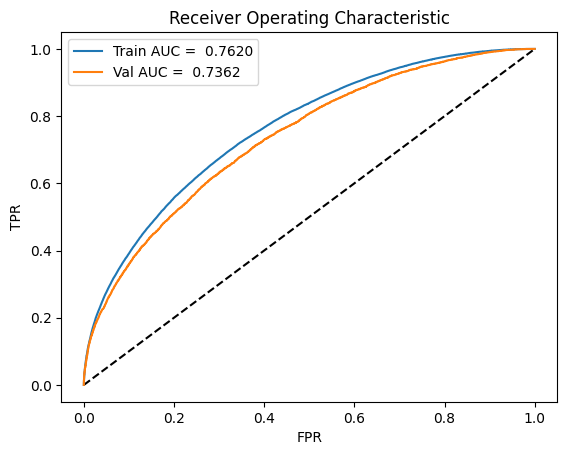

In [ ]:
import tqdm
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

def train(model, learning_rate, epochs, model_name):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=100,
        num_training_steps=len(train_loader) * epochs,
    )

    if use_cuda:

        print('cuda version', torch.__version__)
        model = model.cuda()
        criterion = criterion.cuda()
        
    train_losses = []
    val_losses = []
    
    for epoch_num in range(epochs):
        
        train_preds = []
        train_truths = []
        total_loss_train = 0
        model.train()
            
        for i, batch in enumerate(tqdm.tqdm(train_loader)):

            optimizer.zero_grad()
            batch = batch.to(device)
            output = model(batch)
            label = batch["author", "writes", "paper"].edge_label
            batch_loss = criterion(output, label)
            total_loss_train += batch_loss.item()
            
            train_preds.append(output)
            train_truths.append(label)
            train_losses.append(batch_loss.item())
            
            batch_loss.backward()
            optimizer.step()
            lr_scheduler.step()
#             if i == 100:
#                 break
            
        val_preds = []
        val_truths = []
        total_loss_val = 0
        model.eval()
        
        with torch.no_grad():

            for i, batch in enumerate(tqdm.tqdm(val_loader)):

                batch = batch.to(device)
                output = model(batch)
                label = batch["author", "writes", "paper"].edge_label
                batch_loss = criterion(output, label)
                total_loss_val += batch_loss.item()
                    
                val_preds.append(output)
                val_truths.append(label)
                val_losses.append(batch_loss.item())
#                 if i == 100:
#                     break
               
        train_preds = torch.cat(train_preds, dim=0).detach().cpu().numpy()
        train_truths = torch.cat(train_truths, dim=0).detach().cpu().numpy()
        train_auc = roc_auc_score(train_truths, train_preds)
        val_preds = torch.cat(val_preds, dim=0).detach().cpu().numpy()
        val_truths = torch.cat(val_truths, dim=0).detach().cpu().numpy()
        val_auc = roc_auc_score(val_truths, val_preds)
            
        print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train: .4f} \
                | Train AUC: {train_auc: .4f} \
                | Val Loss: {total_loss_val: .4f} \
                | Val AUC: {val_auc: .4f}')
    
    train_df = pd.DataFrame()
    train_df[model_name] = train_losses
    train_df.to_csv("train_loss.csv", index=False)
    
    val_df = pd.DataFrame()
    val_df[model_name] = val_losses
    val_df.to_csv("val_loss.csv", index=False)
    
    plt.plot([0,1],[0,1], 'k--')
    fpr, tpr, thresh = roc_curve(train_truths, train_preds)
    plt.plot(fpr, tpr, label="Train AUC = {: .4f}".format(train_auc))
    fpr, tpr, thresh = roc_curve(val_truths, val_preds)
    plt.plot(fpr, tpr, label="Val AUC = {: .4f}".format(val_auc))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title('Receiver Operating Characteristic')
    plt.show()

print('There are', sum(p.numel() for p in model.parameters()), 'parameters')
EPOCHS = 3
LR = 2e-5

# PC (BERT)
# PM (BERT + Prompt) 1:3, PM (BERT + Prompt), PM (BERT)
# PS (BERT + Prompt + GraphSAGE) 1:3, PS (BERT + Prompt + GraphSAGE)
train(model, LR, EPOCHS, model_name='PM (BERT + Prompt) 1:3')

### Evaluate

100%|█████████████████████████████████████████| 431/431 [01:53<00:00,  3.78it/s]


Test AUC:  0.7323


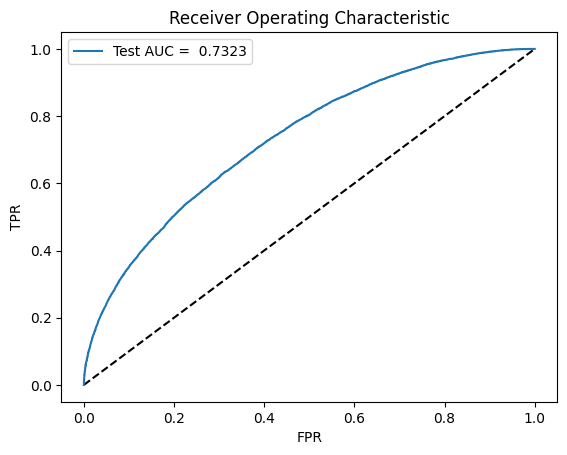

In [ ]:
def evaluate(model, model_name):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_loss_test = 0
    test_preds = []
    test_truths = []
    model.eval()
    
    with torch.no_grad():

        for batch in tqdm.tqdm(test_loader):

            batch = batch.to(device)
            output = model(batch)
            label = batch["author", "writes", "paper"].edge_label
                    
            test_preds.append(output)
            test_truths.append(label)
            
        test_preds = torch.cat(test_preds, dim=0).detach().cpu().numpy()
        test_truths = torch.cat(test_truths, dim=0).detach().cpu().numpy()
        test_auc = roc_auc_score(test_truths, test_preds)
    
    print(f'Test AUC: {test_auc: .4f}')
    plt.plot([0,1],[0,1], 'k--')
    fpr, tpr, thresh = roc_curve(test_truths, test_preds)
    result_df = pd.DataFrame()
    result_df['fpr'] = fpr
    result_df['tpr'] = tpr
    result_df['model'] = model_name
    result_df.to_csv(model_name + ".csv", index=False)
    plt.plot(fpr, tpr, label="Test AUC = {: .4f}".format(test_auc))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title('Receiver Operating Characteristic')
    plt.show()
    
# PC (BERT)
# PM (BERT + Prompt) 1:3, PM (BERT + Prompt), PM (BERT)
# PS (BERT + Prompt + GraphSAGE) 1:3, PS (BERT + Prompt + GraphSAGE)
evaluate(model, model_name='PM (BERT + Prompt) 1:3')

### Test Accuracy Result (from milestone)

- General Setup
    - 2e-5 learning rate
    - 2 epochs
    - 8 batch size
- PC (BERT)
    - Unable to train: over 10k classes (P >> N Problem)
- PM (BERT)
    - 1:1 PN ratio [47.48%]
- PM (BERT + Prompt & Features)
    - 1:1 PN ratio [81.36%]
    - 1:3 PN ratio [90.26%]
- PS (BERT + Prompt & Features + GraphSAGE)
    - over 90%+

### Test AUC Result (from final report)

- General Setup
    - 2e-5 learning rate
    - 3 epochs
    - 128 batch size
- PC (BERT)
    - Unable to train: over 10k classes (P >> N Problem)
- PM (BERT)
    - 1:1 PN ratio [70.66%]
- PM (BERT + Prompt & Features)
    - 1:1 PN ratio [72.62%]
    - 1:3 PN ratio [73.23%]
- PS (BERT + Prompt & Features + GraphSAGE)
    - 1:1 PN ratio [77.49%]
    - 1:3 PN ratio [78.66%]

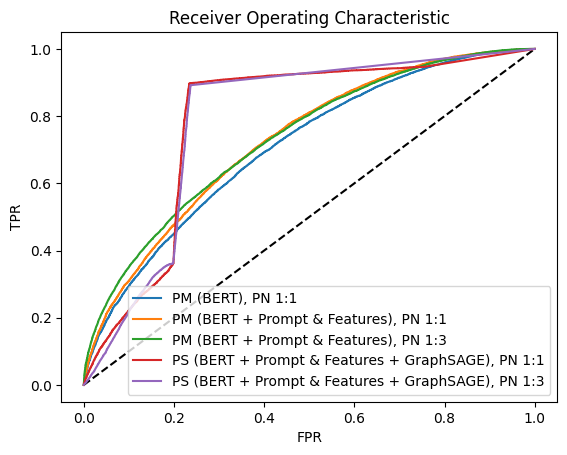

In [ ]:
def plot_roc(model_names, model_labels):
    plt.plot([0,1],[0,1], 'k--')
    for model_name, model_label in zip(model_names, model_labels):
        df = pd.read_csv(model_name + '.csv')
        fpr = df['fpr'].values
        tpr = df['tpr'].values
        plt.plot(fpr, tpr, label=model_label)
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title('Receiver Operating Characteristic')
    plt.show()
    
plot_roc(model_names=['PM (BERT + Prompt)',
                      'PM (BERT)',
                      'PM (BERT + Prompt) 1:3',
                      'PS (BERT + Prompt + GraphSAGE)',
                      'PS (BERT + Prompt + GraphSAGE) 1:3',
                     ],
        model_labels=['PM (BERT), PN 1:1',
                      'PM (BERT + Prompt & Features), PN 1:1',
                      'PM (BERT + Prompt & Features), PN 1:3',
                      'PS (BERT + Prompt & Features + GraphSAGE), PN 1:1',
                      'PS (BERT + Prompt & Features + GraphSAGE), PN 1:3',
                     ])

### Visualization

In [ ]:
data["author"]["node_id"], data["paper"]["node_id"], data["author","writes","paper"]["edge_index"]

(tensor([    0,     1,     2,  ..., 46480, 46481, 46482]),
 tensor([    0,     1,     2,  ..., 89125, 89126, 89127]),
 tensor([[17976,  5533,    25,  ..., 42497, 35869, 30460],
         [    0,     0,     0,  ..., 22280, 22281, 22281]]))

In [ ]:
import networkx as nx
from matplotlib import pyplot as plt

def draw_graph(num_graphs=3, num_edges=500, min_paper_count=1, min_author_count=1, 
               paper_color='blue', author_colors=['green', 'yellow', 'orange']):
    
    author_ids = np.arange(0, len(data["author"]["node_id"]))
    paper_ids = np.arange(len(data["author"]["node_id"]), len(data["paper"]["node_id"]) + len(data["author"]["node_id"]))
   
    for gid in range(num_graphs):
        
        # build graph
        G = nx.Graph()
        for i, (author_id, paper_id) in enumerate(data["author","writes","paper"]["edge_index"].T):
            if num_edges * gid <= i < num_edges * (gid + 1):
                author_key = author_id.item()
                paper_key = paper_id.item() + len(data["author"]["node_id"])
                G.add_edge(author_key, paper_key, key=paper_key)
        removed_authors = []
        removed_papers = []
        for n, d in G.degree():
            if n < len(data["author"]["node_id"]):
                if d < min_paper_count:
                    removed_authors.append(n)
            else:
                if d < min_author_count:
                    removed_papers.append(n)
        G.remove_nodes_from(removed_authors)
        G.remove_nodes_from(removed_papers)
        G.remove_nodes_from([n for n, d in G.degree() if d < 1])
        
        # set attribute
        size_list = []
        color_list = []
        for node in G.nodes:
            if node < len(data["author"]["node_id"]):
                size_list.append(2)
                color_list.append(author_colors[gid])
            else:
                size_list.append(5)
                color_list.append(paper_color)
        
        # draw graph
        nx.draw(G, node_size=size_list, node_color=color_list, with_labels=False)
        
    plt.figure(figsize=(10, 10))
    plt.show()

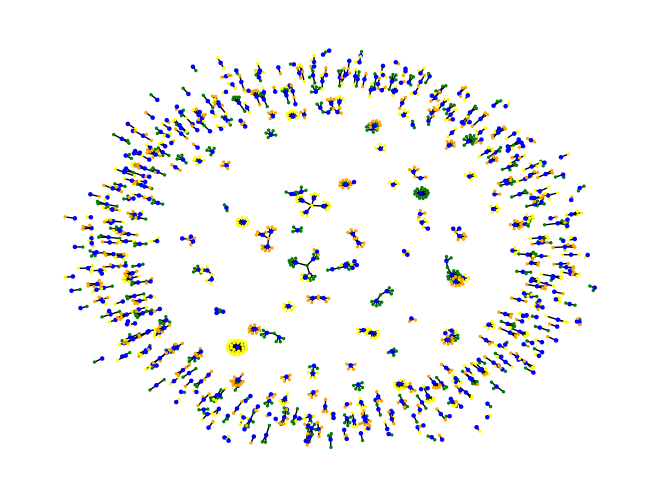

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# draw 3 * 500 author-paper pairs, paper: blue, author: green + yellow + orange
draw_graph()

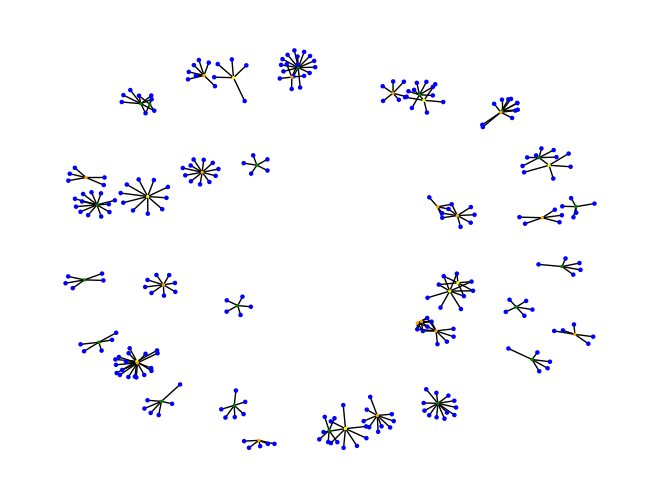

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# draw 3 * 5000 author-paper pairs, but remove authors with paper count < 5
draw_graph(num_edges=5000, min_paper_count=5)

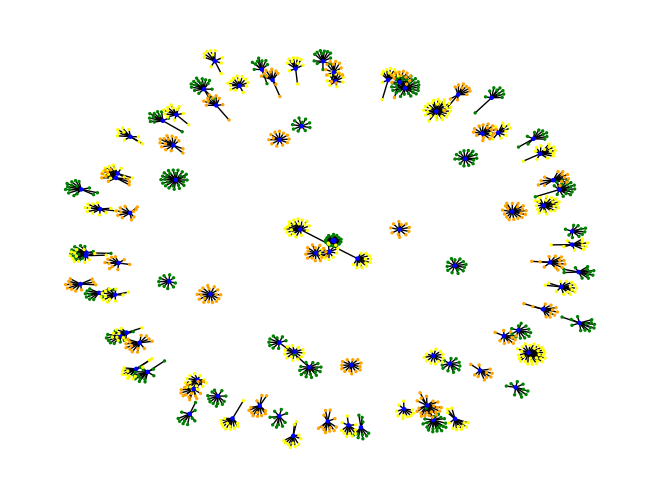

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# draw 3 * 5000 author-paper pairs, but remove papers with author count < 10
draw_graph(num_edges=5000, min_author_count=10)

In [ ]:
import torch_geometric as pyG
import networkx as nx
import scipy

scipy.__version__, nx.__version__, pyG.__version__

('1.9.3', '2.7', '2.2.0')